In [33]:
#%pip install torch
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 200 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 100
n_embd = 512
n_head = 6
n_layer = 6
dropout = 0.2


cuda


In [2]:
##STOCK
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 200 # what is the maximum context length for predictions?
max_iters = 50000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 512
n_head = 6
n_layer = 9
dropout = 0.2


In [34]:
import os
def save(model,file_name='modelStocksBigger.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(),file_name)
    
def load(file_name='modelStocksBigger.pth'):
    model_folder_path = './model'
    
    file_name = os.path.join(model_folder_path, file_name)
    return file_name
    #torch.save(self.state_dict(),file_name)
    


In [35]:
torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('StockDataFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
Alphabet = chars
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


print(len(train_data))

3098962


In [36]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    #print(x,len(y))
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx




In [37]:
model = GPTLanguageModel()
model.load_state_dict(torch.load('./model/modelStocksBigger.pth'))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#print(list(model.signature.keys()))

18.995211 M parameters


In [38]:
for iter in range(max_iters):
   
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        save(model)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.3411, val loss 0.3602


KeyboardInterrupt: 

In [39]:
save(model)

In [18]:
# here are all the unique characters that occur in this text
inputText = "25,24,24,25,25,26,26,27,30,31,32,31,33,32,33,33,32,32,33,33,35,34,34,34,33,33,35,34,35,38,38,37,36"
alphabet = "1234567890,."
inputText = "7.28,3.37,4.94,4.83,5.09,4.34,5.75,3.35,8.48,4.01,4.22,4.55,4.25,6.74,4.97,3.94,6.93,4.83,5.18,5.52,6.30,6.49,3.71,6.50,5.08,6.15,6.83,5.23,5.16"
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ''.join([itosT[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits

dataT = torch.tensor(encoder(inputText), dtype=torch.long)

dataT = dataT.detach().numpy()
print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long)
print(dataT)

[9, 1, 4, 10, 0, 5, 1, 5, 9, 0, 6, 1, 11, 6, 0, 6, 1, 10, 5, 0, 7, 1, 2, 11, 0, 6, 1, 5, 6, 0, 7, 1, 9, 7, 0, 5, 1, 5, 7, 0, 10, 1, 6, 10, 0, 6, 1, 2, 3, 0, 6, 1, 4, 4, 0, 6, 1, 7, 7, 0, 6, 1, 4, 7, 0, 8, 1, 9, 6, 0, 6, 1, 11, 9, 0, 5, 1, 11, 6, 0, 8, 1, 11, 5, 0, 6, 1, 10, 5, 0, 7, 1, 3, 10, 0, 7, 1, 7, 4, 0, 8, 1, 5, 2, 0, 8, 1, 6, 11, 0, 5, 1, 9, 3, 0, 8, 1, 7, 2, 0, 7, 1, 2, 10, 0, 8, 1, 3, 7, 0, 8, 1, 10, 5, 0, 7, 1, 4, 5, 0, 7, 1, 3, 8]
[9, 1, 4, 10, 0, 5, 1, 5, 9, 0, 6, 1, 11, 6, 0, 6, 1, 10, 5, 0, 7, 1, 2, 11, 0, 6, 1, 5, 6, 0, 7, 1, 9, 7, 0, 5, 1, 5, 7, 0, 10, 1, 6, 10, 0, 6, 1, 2, 3, 0, 6, 1, 4, 4, 0, 6, 1, 7, 7, 0, 6, 1, 4, 7, 0, 8, 1, 9, 6, 0, 6, 1, 11, 9, 0, 5, 1, 11, 6, 0, 8, 1, 11, 5, 0, 6, 1, 10, 5, 0, 7, 1, 3, 10, 0, 7, 1, 7, 4, 0, 8, 1, 5, 2, 0, 8, 1, 6, 11, 0, 5, 1, 9, 3, 0, 8, 1, 7, 2, 0, 7, 1, 2, 10, 0, 8, 1, 3, 7, 0, 8, 1, 10, 5, 0, 7, 1, 4, 5, 0, 7, 1, 3, 8]
tensor([ 9,  1,  4, 10,  0,  5,  1,  5,  9,  0,  6,  1, 11,  6,  0,  6,  1, 10,
         5,  0,  7,  1,  2

In [23]:
import matplotlib.pyplot as plt
context = dataT#torch.tensor(dataInput)
output = decode(m.generate(context.reshape(1,len(context)), max_new_tokens=block_size*2)[0].tolist())
print(output.replace("-","."))


5.94,2.71,3.39,4.06,4.30,4.40,4.08,3.24,4.82,2.95,3.30,1.66,3.30,4.04,6.96,3.12,1.61,2.95,3.18,2.96,2.45,4.09,4.64,4.28,4.20,2.56,4.99,3.02,5.86,4.66,4.80,4.56,4.71,4.86,4.85,3.59,6.84,3.20,2.60,2.66,3.09,4.99,3.85,4.30,3.56,2.99,


In [8]:
real = "7.28,3.37,4.94,4.83,5.09,4.34,5.75,3.35,8.48,4.01,4.22,4.55,4.25,6.74,4.97,3.94,6.93,4.83,5.18,5.52,6.30,6.49,3.71,6.50,5.08,6.15,6.83,5.23,5.16,4.23,2.39,4.23,5.44,5.45,6.47,6.94,6.59,3.01,5.19,5.37,4.41,6.86,5.89,4.55,6.07,4.06,6.54,5.68,4.06,7.30,4.54,3.96,5.65,2.51,6.06,4.04,4.33,5.40,6.41,5.94,3.73,5.57,5.60,3.37,6.77,4.25,4.45,4.84,4.60,4.36,3.84,4.59,7.46,3.72,3.15,5.06,6.13,5.16,7.47,5.50,4.14,5.02,5.26,5.02,4.39,4.07,4.46,6.70,5.17,6.00,5.17,5.42,5.49,4.15,6.33,4.49,4.70,4.16,5.86,5.15,6.37,5.41,4.60,4.20,4.78,6.75,4.17,5.55,5.65,5.91,5.57,3.94,4.41,6.70,5.48,3.94,6.70,3.51,4.55,4.99,6.19,6.89,6.16,5.60"
op = output.split(",")
out = []
for i in range(len(op)):
    try:
        float(op[i])
        out.append(op[i])
    except:
        print(op[i])
        pass
outputFinal = np.array(out,dtype=float)

plt.plot(outputFinal)
plt.plot(np.array(real.split(","),dtype=float),color = "red")
plt.plot(np.array(inputText.split(","),dtype=float),color = "yellow")
plt.show()
trueCount = 0
print(len(real.split(",")),len(outputFinal))
for i in range(0,len(outputFinal)):
    if float(real.split(",")[i]) == float(outputFinal[i]):
        trueCount+=1
Accuracy = trueCount/len(real.split(","))
print(Accuracy)
trueOut = real

NameError: name 'output' is not defined

[7.280e+00 3.370e+00 4.940e+00 4.830e+00 5.090e+00 4.340e+00 5.750e+00
 3.350e+00 8.480e+00 4.010e+00 4.220e+00 4.550e+00 4.250e+00 6.740e+00
 4.970e+00 3.940e+00 6.930e+00 4.830e+00 5.180e+00 5.520e+00 6.300e+00
 6.490e+00 3.710e+00 6.500e+00 5.080e+00 6.150e+00 6.830e+00 5.230e+00
 5.160e+00 4.790e+00 7.930e+00 3.820e+00 4.210e+00 6.150e+00 5.280e+00
 4.360e+00 6.780e+00 6.590e+00 4.150e+00 6.000e+00 3.350e+00 4.070e+00
 5.560e+00 3.260e+00 5.660e+00 5.530e+00 5.310e+00 6.390e+00 5.620e+00
 3.580e+00 5.290e+00 6.510e+00 5.630e+00 3.280e+00 4.680e+00 4.410e+00
 6.030e+00 4.510e+00 4.760e+00 5.070e+00 3.280e+00 5.840e+00 5.330e+00
 4.070e+00 4.180e+00 5.500e+00 4.370e+00 5.410e+00 6.590e+00 3.930e+00
 5.790e+00 6.670e+00 9.100e-01 4.280e+00 3.080e+00 5.770e+00 5.020e+00
 3.260e+00 6.400e+00 6.730e+00 4.890e+00 4.540e+00 4.360e+00 5.040e+00
 3.670e+00 3.170e+00 5.900e+00 4.090e+00 5.620e+00 6.070e+00 4.200e+00
 4.460e+00 3.600e+00 3.460e+00 4.310e+00 6.290e+00 3.680e+00 7.010e+00
 5.730

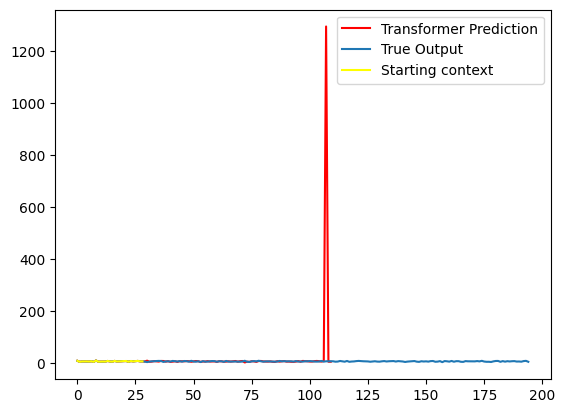

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [13]:
import re
import matplotlib.pyplot as plt
trueOut = "25,24,24,25,25,26,26,27,30,31,32,31,33,32,33,33,32,32,33,33,35,34,34,34,33,33,35,34,35,38,38,37,36,37,33,34,35,34,35,35,35,36,36,36,36,36,35,35,35,35,35,34,35,34,33,35,35,35,35,34,34,35,33,31,34,35,33,31,28,28,28,28,28,28,29,30,30,29,30,30,31,31,31,30,32,32,32,31,30,30,30,29,29,28,28,29,29,29,28,29,30,30,31,31,30,31,31,31,31,31,31,31,30,30,30,31,31,31,31,31,31,31,32,31,32,32,31,31,32,32,32,32,32,32,32,32,33,33,34,34"
trueOut = real
trueOut = "7.28,3.37,4.94,4.83,5.09,4.34,5.75,3.35,8.48,4.01,4.22,4.55,4.25,6.74,4.97,3.94,6.93,4.83,5.18,5.52,6.30,6.49,3.71,6.50,5.08,6.15,6.83,5.23,5.16,4.23,2.39,4.23,5.44,5.45,6.47,6.94,6.59,3.01,5.19,5.37,4.41,6.86,5.89,4.55,6.07,4.06,6.54,5.68,4.06,7.30,4.54,3.96,5.65,2.51,6.06,4.04,4.33,5.40,6.41,5.94,3.73,5.57,5.60,3.37,6.77,4.25,4.45,4.84,4.60,4.36,3.84,4.59,7.46,3.72,3.15,5.06,6.13,5.16,7.47,5.50,4.14,5.02,5.26,5.02,4.39,4.07,4.46,6.70,5.17,6.00,5.17,5.42,5.49,4.15,6.33,4.49,4.70,4.16,5.86,5.15,6.37,5.41,4.60,4.20,4.78,6.75,4.17,5.55,5.65,5.91,5.57,3.94,4.41,6.70,5.48,3.94,6.70,3.51,4.55,4.99,6.19,6.89,6.16,5.60,5.28,4.97,3.76,4.69,5.63,4.35,4.03,5.38,6.29,4.76,5.64,5.82,6.39,4.57,6.18,5.66,4.72,2.89,4.29,5.04,5.77,6.42,4.10,3.29,5.65,4.66,5.29,4.20,6.16,6.58,3.65,4.24,6.09,2.15,6.36,5.52,4.14,6.75,3.84,5.94,5.89,3.59,3.22,6.20,5.44,5.46,5.15,5.17,6.31,5.10,7.24,4.56,3.56,3.62,2.87,5.22,6.67,6.81,3.47,6.17,4.11,5.88,4.84,5.76,6.15,4.48,4.71,3.94,6.31,7.15,3.55"
# generate from the model
#context = torch.ones((1, 1), dtype=torch.long, device=device) # this is what i need to input into
context = dataT#torch.tensor(dataInput)

#context = torch.tensor([[23],[25]],dtype=torch.long)
#print(inputText)
#print(context.reshape(1,len(context)))
for j in range(0,15):

    output = decode(m.generate(context.reshape(1,len(context)), max_new_tokens=block_size*4+1)[0].tolist())
    outputT = output.split(",")
    for i in range(0,len(outputT)):
        if (outputT[i]) == '':
            outputT[i] = outputT[i-1]
        
    temp = np.array(outputT,dtype=float)
    print(temp)
    line1 = plt.plot(temp,color="red",label="Transformer Prediction")
    line2 = plt.plot(np.array(trueOut.split(","),dtype=float),label="True Output")
    line3 = plt.plot(np.array(inputText.split(","),dtype=float),color = "yellow",label="Starting context")
    plt.legend()
    plt.savefig("Graphs/Graph"+str(j))
  
    plt.show()
    trueCount = 0
    #print(len(real.split(",")),len(outputFinal))
    for i in range(0,len(temp.split(","))):
        if float(real.split(",")[i]) == float(outputFinal[i]):
            trueCount+=1
    Accuracy = trueCount/len(temp.split(","))
    print(Accuracy)
        
    print(output)#.replace("\n\n",""))

#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

In [18]:
import numpy as np
import numpy as np

def KL(P,Q):
     P = np.asarray(P, dtype=np.float)
     Q = np.asarray(Q, dtype=np.float)
     epsilon = 0.00001

     # You may want to instead make copies to avoid changing the np arrays.
     P = P+epsilon
     Q = Q+epsilon

     divergence = np.sum(P*np.log(P/Q))
     return divergence

values1 = output.split(",")

values2 = trueOut.split(",")
maxOut = len(values2)
print(maxOut)
#print (KL(values1[:maxOut], values2[:maxOut]))
from sklearn.metrics import mutual_info_score as pp
pp(values1[:maxOut], values2[:maxOut])

81


4.137727976687273

[6, 1, 3, 10, 0, 6, 1, 9, 6, 0, 6, 1, 5, 4, 0, 4, 1, 5, 5, 0]
[6, 1, 3, 10, 0, 6, 1, 9, 6, 0, 6, 1, 5, 4, 0, 4, 1, 5, 5, 0]
tensor([ 6,  1,  3, 10,  0,  6,  1,  9,  6,  0,  6,  1,  5,  4,  0,  4,  1,  5,
         5,  0])
pp
4.18,4.74,4.32,2.33,2.59,4.30,4.71,3.60,2.31,5.40,5.10,5.11,2.45,4.15,4.46,4.66,4.56,3.12,4.14,0.90,5.73,4.00,3.90,7.65,4.67,4.22,3.72,4.73,2.34,2.17,1.77,3.98,5.60,4.46,4.64,3.31,4.84,4.15,3.34,2.68,4.50,3.05,4.54,2.75,
41
45 41 41
                        Transformer prediction  True correlation  \
Transformer prediction                1.000000          1.000000   
True correlation                      1.000000          1.000000   
Test correlation                     -0.002902         -0.002902   

                        Test correlation  
Transformer prediction         -0.002902  
True correlation               -0.002902  
Test correlation                1.000000  


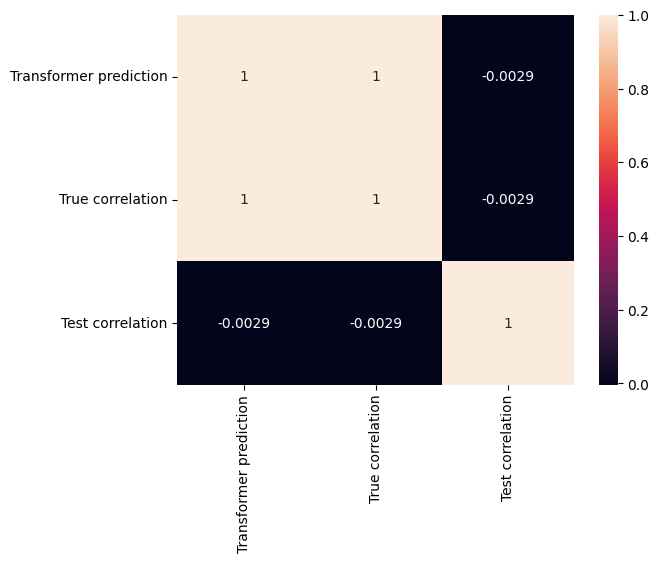

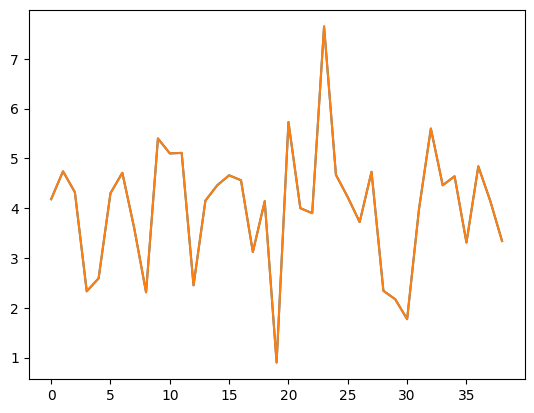

In [10]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
device = 'cpu'
alphabet = Alphabet

f = open("CorrelationData.txt", "r", errors="ignore", encoding="utf-8")
inputText = f.read()[:20]
f.close()
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ''.join([itosT[i] for i in l])
dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cpu')
dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)

output = (decode(m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*2)[0].tolist()))
print("pp")
print(output)
f = open("TestCorrelation.txt", "r", errors="ignore", encoding="utf-8")

tempTri = f.read()[:block_size*2]
f.close()
f = open("CorrelationData.txt", "r", errors="ignore", encoding="utf-8")

trueOut = f.read()[:block_size*2]
f.close()
print(len(tempTri.split(",")))
maxOut = 40
print(len(output.split(",")),len(trueOut.split(",")),len(tempTri.split(",")))
data = {'Transformer prediction': np.array(output.split(",")[:maxOut][:-1],dtype=float),
        'True correlation': np.array(trueOut.split(",")[:maxOut][:-1],dtype=float),
        'Test correlation': np.array(tempTri.split(",")[:maxOut][:-1],dtype=float)
        }
#print(len(tempTri.split(",")[:maxOut]),len(trueOut.split(",")[:maxOut]))
df = pd.DataFrame(data)
print(df.corr())
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()
plt.plot(np.array(output.split(",")[:maxOut][:-1],dtype=float))
plt.plot(np.array(trueOut.split(",")[:maxOut][:-1],dtype=float))
plt.show()


[4, 2, 0, 3, 10, 0, 3, 9, 0, 3, 10, 0, 3, 8, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0, 4, 1, 0, 4, 1, 0, 4, 2, 0, 4, 2, 0, 4]
[4, 2, 0, 3, 10, 0, 3, 9, 0, 3, 10, 0, 3, 8, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0, 3, 9, 0, 4, 1, 0, 4, 1, 0, 4, 2, 0, 4, 2, 0, 4]
tensor([ 4,  2,  0,  3, 10,  0,  3,  9,  0,  3, 10,  0,  3,  8,  0,  3,  9,  0,
         3,  9,  0,  3,  9,  0,  3,  9,  0,  4,  1,  0,  4,  1,  0,  4,  2,  0,
         4,  2,  0,  4])
pp
31,29,28,29,27,28,28,28,28,30,30,31,31,31,32,32,31,30,30,31,30,31,31,33,34,34,34,33,31,33,33,33,33,33,33,32,33,33,32,32,33,33,32,33,32,32,32,32,32,32,32,31,31,31,32,31,31,31,31,30,31,32,32,32,33,32,32,32,32,31,32,32,32,232,2,23,222,2,232,3,223,2,233,29,23,22,23,23,23,22,23,23,23,23,23,23,23,23,24,23,23,23,13,23,32,23,13,23,13,23,13,13,13,13,13,13,13,33,13,33,32,33,32,33,32,33,32,32,32,33,32,32,33,33,33,33,33,33,33,33,33,33,33,33,33,33,3
300
79
147 133 300
                        Transformer prediction  True Stock
Transformer prediction                1.000000 

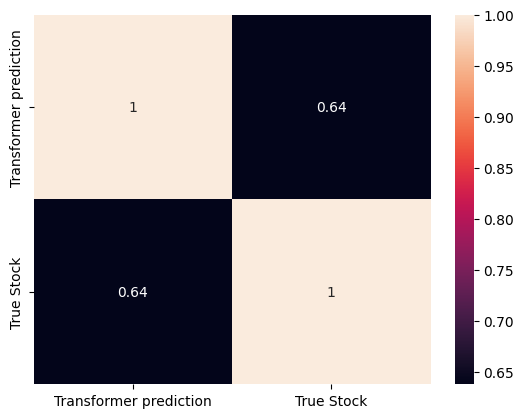

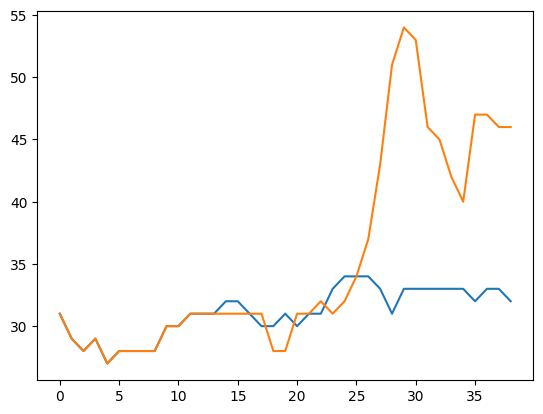

In [41]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
device = 'cpu'
alphabet = Alphabet
f = open("StockDataFile.txt", "r", errors="ignore", encoding="utf-8")
inputText = f.read()[:40]
f.close()
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ''.join([itosT[i] for i in l])
dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cpu')
dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)

output = (decode(m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*2)[0].tolist()))
print("pp")
print(output)
f = open("StockDataFile.txt", "r", errors="ignore", encoding="utf-8")

tempTri = f.read()[:block_size*2+block_size*2]
f.close()
f = open("StockDataFile.txt", "r", errors="ignore", encoding="utf-8")

trueOut = f.read()[:block_size*2]
f.close()
print(len(tempTri.split(",")))
maxOut = 40
print(len(np.array(tempTri.split(",")[maxOut*4:][:maxOut*2-1],dtype=float)))
print(len(output.split(",")),len(trueOut.split(",")),len(tempTri.split(",")))
data = {'Transformer prediction': np.array(output.split(",")[:maxOut][:-1],dtype=float),
        'True Stock': np.array(trueOut.split(",")[:maxOut][:-1],dtype=float),
        #'Test Stock': np.array(tempTri.split(",")[maxOut*4:][:(maxOut)-1],dtype=float)
        }
#print(len(tempTri.split(",")[:maxOut]),len(trueOut.split(",")[:maxOut]))
df = pd.DataFrame(data)
print(df.corr())
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()
plt.plot(np.array(output.split(",")[:maxOut][:-1],dtype=float))
plt.plot(np.array(trueOut.split(",")[:maxOut][:-1],dtype=float))
plt.show()


25,24,24,25,25,26,26,27,30,31,32,31,33,32,33,33,32,32,33,33,35,34,34,34,33,33,35,34,35,38,38,37,36,37,33,34,35,34,35,35,35,36,36,36,36,36,35,35,35,35,35,34,35,34,33,35,35,35,35,34,34,35,33,31,34,35,33,31,28,28,28,28,28,28,29,30,30,29,30,30,31,31,31,30,32,32,32,31,30,30,30,29,29,28,28,29,29,28,29,28,29,26,29,26,26,26,27,25,26,25,26,24,26,26,24,26,24,26,25,24,25,25,23,25,25,26,24,25,24,24,24,25,25,24,24,24,25,23,25,24,25,24,24,24,23,24,23,23,24,23,24,23,23,23,23,24,23,24,23,24,23,23,23,
[25 24 24 25 25 26 26 27 30 31 32 31 33 32 33 33 32 32 33 33 35 34 34 34
 33 33 35 34 35 38 38 37 36 37 33 34 35 34 35 35 35 36 36 36 36 36 35 35
 35 35 35 34 35 34 33 35 35 35 35 34 34 35 33 31 34 35 33 31 28 28 28 28
 28 28 29 30 30 29 30 30 31 31 31 30 32 32 32 31 30 30 30 29 29 28 28 29
 29 28 29 28 29 26 29 26 26 26 27 25 26 25 26 24 26 26 24 26 24 26 25 24
 25 25 23 25 25 26 24 25 24 24 24 25 25 24 24 24 25 23 25 24 25 24 24 24
 23 24 23 23 24 23 24 23 23 23 23 24 23 24 23 24 23 23 23 23]


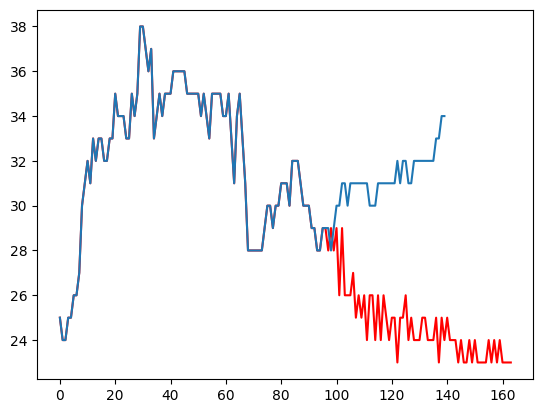

In [ ]:

print(output)
outputT = output.split(",")
for i in range(0,len(outputT)):
    if (outputT[i]) == '':
        outputT[i] = outputT[i-1]
    
temp = np.array(outputT,dtype=int)
print(temp)
plt.plot(temp,color="red")
plt.plot(np.array(trueOut.split(","),dtype=int))
plt.show()

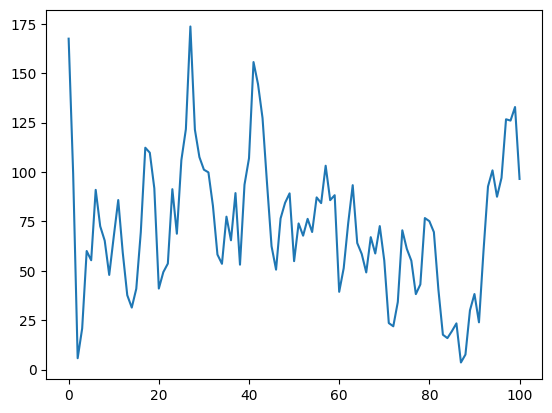

In [104]:
pN = "167.48, 99.26, 5.78, 20.86, 60.03, 55.35, 90.97, 72.56, 65.26, 47.93, 67.26, 85.82, 59.22, 37.67, 31.4, 40.92, 69.53, 112.3, 109.77, 91.77, 41.04, 49.36, 53.66, 91.32, 68.77, 106.03, 121.69, 173.65, 121.44, 107.55, 101.18, 99.83, 82.87, 58.24, 53.55, 77.41, 65.46, 89.34, 53.11, 93.59, 106.96, 155.64, 144.44, 127.3, 94.13, 62.45, 50.6, 76.49, 84.4, 89.2, 54.89, 73.98, 67.79, 76.3, 69.64, 87.16, 84.26, 103.18, 85.75, 88.27, 39.38, 51.33, 74.16, 93.35, 64.08, 58.53, 49.18, 67.04, 58.77, 72.63, 55.16, 23.56, 21.93, 34.22, 70.5, 61.11, 55.12, 38.21, 43.12, 76.7, 75.12, 69.6, 40.55, 17.65, 15.95, 19.47, 23.4, 3.62, 7.63, 29.98, 38.26, 23.94, 59.85, 92.68, 100.84, 87.49, 97.04, 126.69, 126.03, 132.9, 96.5"
pNoise = np.array(pN.split(","),dtype=float)
plt.plot(pNoise)

In [105]:
p = output
output = p

In [25]:
import math 
arr = []
for i in range(0,400):
    arr.append(round((math.sin(i/10)*100+100),0))
import matplotlib.pyplot as plt
#plt.plot(arr)
f = open("MathFunc.txt", "a", errors="ignore", encoding="utf-8")
f.write(str(arr))

2559

[3, 2, 3, 1, 0, 4, 5, 3, 2, 3, 1, 0, 4, 6, 3, 2, 3, 1, 0, 4, 6, 12, 2, 3, 1, 0, 4, 7, 11, 2, 3, 1, 0, 4, 8, 9, 2, 3, 1, 0, 4, 9, 7, 2, 3, 1, 0, 4, 10, 5, 2, 3, 1, 0, 4, 10, 11, 2, 3, 1, 0, 4, 11, 7, 2, 3, 1, 0, 4, 11, 12, 2, 3, 1, 0, 4, 12, 6, 2, 3, 1, 0, 4, 12, 9, 2, 3, 1, 0, 4, 12, 12, 2, 3, 1, 0, 5, 3, 3, 2, 3, 1, 0, 5, 3, 3, 2, 3, 1, 0, 4, 12, 12, 2, 3, 1, 0, 4, 12, 10, 2, 3, 1, 0, 4, 12, 8, 2, 3, 1, 0, 4, 12, 4, 2, 3, 1, 0, 4, 11, 9, 2, 3, 1, 0, 4, 11, 4, 2, 3, 1, 0, 4, 10, 8, 2, 3, 1, 0, 4, 9, 11, 2, 3, 1, 0, 4, 9, 3, 2, 3, 1, 0, 4, 8, 5, 2, 3, 1, 0, 4, 7, 6, 2, 3, 1, 0, 4, 6, 6, 2, 3, 1, 0, 4, 5, 7, 2, 3, 1, 0, 4, 4, 7, 2, 3, 1, 0, 4, 3, 7, 2, 3, 1, 0, 12, 7, 2, 3, 1, 0, 11, 7, 2, 3, 1, 0, 10, 7, 2, 3, 1, 0, 9, 8, 2, 3, 1, 0, 8, 9, 2, 3, 1, 0, 7, 10, 2, 3, 1, 0, 6, 12, 2, 3, 1, 0, 6, 4, 2, 3, 1, 0, 5, 7, 2, 3, 1, 0, 4, 11, 2, 3, 1, 0, 4, 6, 2, 3, 1, 0, 11, 2, 3, 1, 0, 8, 2, 3, 1, 0, 5, 2, 3, 1, 0, 4, 2, 3, 1, 0, 3, 2, 3, 1, 0, 3, 2, 3, 1, 0, 5, 2, 3, 1, 0, 7, 2, 3, 1, 0, 10, 2, 

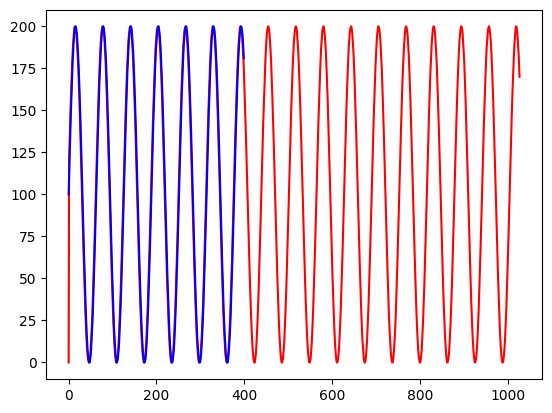

299 77
                        Transformer prediction  True Stock
Transformer prediction                1.000000    0.981872
True Stock                            0.981872    1.000000


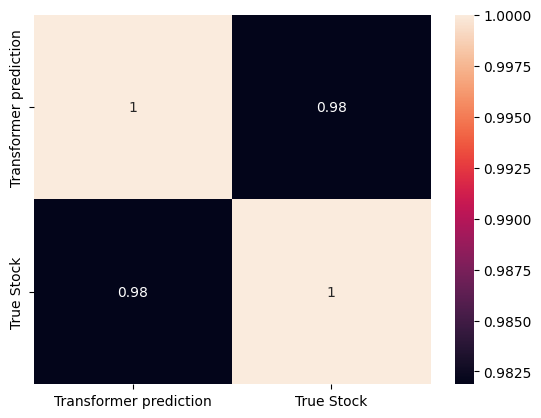

In [27]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
device = 'cpu'
alphabet = "1234567890,. "
f = open("MathFunc.txt", "r", errors="ignore", encoding="utf-8")
inputText = f.read()[10:]
f.close()
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ''.join([itosT[i] for i in l])
dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cpu')
dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)

output = (decode(m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*2)[0].tolist()))
output = output.replace("][",",")
output.split(",").pop()
print(output.split(","))
StockArr = np.array(output.split(",")[:-1],dtype=float)


#StockStr = '31,29,28,29,27,28,28,28,28,30,30,31,31,31,31,31,31,31,28,28,31,31,32,31,32,34,37,43,51,54,53,46,45,42,40,47,47,46,46,45,46,49,48,47,46,46,46,47,47,46,45,49,51,52,52,55,52,52,52,51,52,54,55,60,65,62,68,70,73,68,71,74,71,76,105,99,99,103,88,90,86,78,81,81,75,77,81,80,80,77,80,73,72,70,66,63,66,73,82,68,66,59,59,54,53,59,59,59,64,64,60,61,60,66,66,62,61,62,58,53,52,57,61,61,56,53,49,45,42,39,40,'
#StockArrT = StockStr.split(",")

print(StockArr)
plt.plot(StockArr,color="red")
plt.plot(arr,color="blue")
plt.show()
import pandas as pd
print(len(np.array(output.split(",")[:block_size*3][:-1],dtype=float)),len(np.array(arr[:78][:-1],dtype=float)))
data = {'Transformer prediction': np.array(output.split(",")[:78][:-1],dtype=float),
        'True Stock': np.array(arr[:78][:-1],dtype=float),
        #'Test Stock': np.array(tempTri.split(",")[maxOut*4:][:(maxOut)-1],dtype=float)
        }
df = pd.DataFrame(data)
print(df.corr())
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

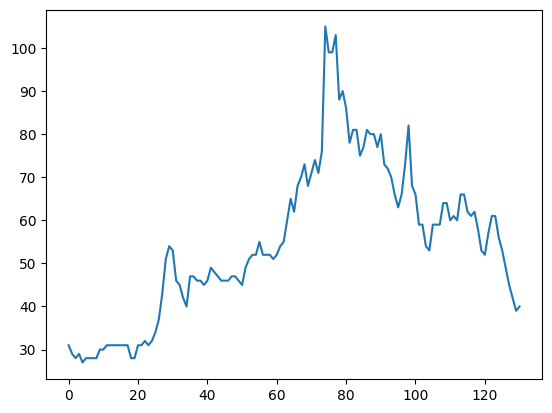

In [31]:
StockStr = '31,29,28,29,27,28,28,28,28,30,30,31,31,31,31,31,31,31,28,28,31,31,32,31,32,34,37,43,51,54,53,46,45,42,40,47,47,46,46,45,46,49,48,47,46,46,46,47,47,46,45,49,51,52,52,55,52,52,52,51,52,54,55,60,65,62,68,70,73,68,71,74,71,76,105,99,99,103,88,90,86,78,81,81,75,77,81,80,80,77,80,73,72,70,66,63,66,73,82,68,66,59,59,54,53,59,59,59,64,64,60,61,60,66,66,62,61,62,58,53,52,57,61,61,56,53,49,45,42,39,40'
StockArrT = np.array(StockStr.split(","),dtype=int)
x=[]
for i in range(len(StockArrT)):
    x.append(i)
plt.plot(x,StockArrT)

In [27]:
import re
# generate from the model
context = torch.ones((3, 1), dtype=torch.long, device=device)

#context = torch.tensor([[15]],dtype=torch.long)
output = decode(m.generate(context, max_new_tokens=block_size)[0].tolist())
print(output)#.replace("\n\n",""))

#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0,30,30,30,30,30,30,30,30,30,30,30,30,29,30,27,27,28,27,10,9,9,9,9,9,9,10,9,10,9,9,10,10,10,10,9,10,10,10,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,10,20,22,22,22,22,22,22,20,22,2
